In [1]:
"""
Forward model
"""
import numpy as np
#from numba.decorators import jit
from scipy import interpolate as ip
#from scipy import optimize as opt
import sys
from configparser import ConfigParser as scp
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
import csv
from pandas import DataFrame, read_csv
import pandas as pd
import random
import ipdb

Ds = np.array([[726 * 10**-6], [364 * 10**-6], [182 * 10**-6],
               [91 * 10**-6],
               [46 * 10**-6]])  # representative diameters of grain-size classes
cnum = len(Ds)  # number of grain-size classes
nu = 1.010 * 10**-6  # kinetic viscosity of water (m^2 / s)
R = 1.65  # submerged specific density of water
Cf = 0.004  # friction coefficient (dimensionless Chezy coeff.)
ngrid = 50  # number of grids for transforming coordinate
sp_grid_num = 300  # number of grids for fixed coordinate
lambda_p = 0.4  # sediment porocity
dt = 0.0003  # time step length
x0 = 10.  # m initial location of the flow head
g = 9.81  # m/s^2 gravity acceleration

spoints = []  # m location of sampling points (distance from the coastline)
deposit = []  # volume-per-unit-area of each grain-size class at each location
topodx = 5.0
Rw = 0
U = 0
H = 0
T = 0
C0 = []
ws = []


def read_setfile(configfile):
    """
    A function for parsing a confuguration file to set basic parameters
    """
    global nu, R, Cf, ngrid, sp_grid_num, lambda_p, dt, x0, g, Ds, cnum, topodx
    parser = scp()
    parser.read(configfile)  # read a configuration file

    nu = parser.getfloat("Physical variables", "nu")  # kinematic viscosity
    # submerged spec. density of sediment
    R = parser.getfloat("Sediments", "R")
    Cf = parser.getfloat("Physical variables", "Cf")  # friction coefficient
    ngrid = parser.getint("Calculation", "ngrid")  # number of grids for a flow
    sp_grid_num = parser.getint("Calculation", "sp_grid_num")  # num of grids
    lambda_p = parser.getfloat("Sediments", "lambda_p")  # sediment porocity
    dt = parser.getfloat("Calculation", "dt")  # time step length
    x0 = parser.getfloat("Calculation", "x0")  # initial location of flow head
    g = parser.getfloat("Physical variables", "g")  # gravity acceleration
    topodx = parser.getfloat("Calculation", "topodx")

    Ds_text = parser.get("Sediments", "Ds")  # grain sizes as strings
    # converting strings of grain diameter to numbers
    Ds_micron = [float(x) for x in Ds_text.split(',') if len(x) != 0]
    Ds = np.array(Ds_micron) * 10**-6  # converting micron to m
    Ds = np.array(np.matrix(Ds).T)  # transpose the matrix
    cnum = len(Ds)  # number of grain-size classes


def set_spoint_interval(topodx, sp_grid_num):
    """
    A function to set locations of sampling points
    """
    global spoints
    # spoints = np.linspace(0, Rw, sp_grid_num)
    spoints = np.arange(0, topodx * sp_grid_num, topodx)
    #ipdb.set_trace()
    
def forward(optim_params):
    """
    Calculate the forward model
    the model calculates depositon both from tsunami inundation flow and 
    stagnant phases of the flow

    Parameters
    ----------
    optim_params: a numpy array


    Returns
    -------
    x: ndarray
        location of transforming grids of flows
    C: ndarray (number of grain-size classes, num of trans. grids)
        sediment concentration at x
    spoints: ndarray
        x coordinates for deposits
    deposit_grainsize: ndarray (number of grain-size classes, num of trans. grids)
        volume-per-unit-area of each grain-size class

    """
    global deposit

    # ipdb.set_trace()
    set_params(optim_params)  # set initial parameters

    # making initial arrays
    cnum = len(Ds)  # number of grain-size classes

    # spatial coordinates in dimensionless transforming grid (0-1.0)
    x_hat = np.linspace(0, 1.0, ngrid)
    dx = x_hat[1] - x_hat[0]  # grid spacing in dimensionless trans. grid
    C = C0 * (1.0 - x_hat)  # initial sed. concentration (dimensionless space)
    # initial dep. thick. (real space)
    deposit = np.zeros((cnum, len(spoints)))
    # np.reshape(deposit,(1000,100))
    # grain size fractions in active layer on the top of deposit
    Fi_r = np.ones((cnum, len(spoints))) / cnum
    #Fi_r = np.ones((Ds,len(spoints)))/Ds
    # bed aggradation rate. i.e. \frac{d eta}{dt}
    detadt = np.zeros((cnum, ngrid))
    #detadt = np.zeros((Ds,ngrid))
    t_hat = x0 / Rw  # dimensionless time
    # arrays to record grain size fractions and agg. rate at previous time step
    dFi_r_dt_prev = []
    detadt_r_prev = []

    Cmax = np.max(C0)  # a variable to check divergence of calculation
    while (t_hat < 1.0) and (Cmax < 1.0):
        t_hat += dt  # increment the dimensionless time
        # calculation of 1 time step
        (C, deposit, Fi_r, detadt, dFi_r_dt_prev, detadt_r_prev) =\
            step(t_hat, x_hat, C, dt, dx,
                 deposit,
                 Fi_r, detadt, dFi_r_dt_prev, detadt_r_prev)
        # check divergence of calculation
        Cmax = np.max(np.absolute(C))

    if t_hat < 1.0:  # abort when calculation diverged
        deposit = deposit / t_hat * 100
        sys.stderr.write('C Exceeded 1.0\n')

    x = Rw * x_hat  # convert dimensionless coord. to real space
    # deposition after the termination of flow inundation
    deposit = get_final_deposit(x, C, spoints, deposit)

    # return values of x coord. of flows, concentration, //
    #    x coord. of real space and deposit thickness
    return (x, C, spoints, deposit)


def get_final_deposit(x, C, spoints, deposit):
    """
    calculation of deposition after termination of inundation flow 

    Parameters
    ----------
    x: ndarray
        dimensional spatial coordinate of moving coordinate
    C: 2d ndarray(cnum, ngrid)
        sediment concentration
    spoints: ndarray
        fixed spatial coordiate
    deposit: 2d ndarray(cnum, sp_grid_num)
        Volume-per-unit-area of each grain-size class

    Return
    ----------
    deposit: 2d ndarray(cnum, sp_grid_num)
        Volume-per-unit-area of each grain-size class after deposition from
        stagnant flow

    """
    # np.loadtxt("start_param_random_5000_Rwcnst.csv",delimiter=',')
    h = -H / Rw * spoints + H
    f = ip.interp1d(x, C, kind='linear', bounds_error=False, fill_value=0.0)
    C_r = f(spoints)
    deposit += (h * C_r) / (1 - lambda_p)
    return deposit


def step(t_hat, x_hat, C, dt, dx,
         deposit,
         Fi_r, detadt, dFi_r_dt_prev, detadt_r_prev):
    """
    calculate amounts of deposition and variation of transported sediment
    concentration within one time step

    The two-step Adams-Bashforth Predictor-Corrector method is used for
    calculation of deposition. The AD-PC method requires values of the first
    and second steps, so that Runge-Kutta method is used to obtain the second
    step values.

    The implicit Euler method is used for calculation of suspended sediment
    transport.

    Parameters
    ----------
    t_hat: float
        dimensionless time (1.0 at the end of calculation)

    x_hat: float
        dimensionless spatial coordinate (1.0 at the head of flows)

    C: 2d ndarray(cnum, ngrid)
        sediment concentration

    dt: float
        time step length

    dx: float
        spatial step length in dimensionless space

    deposit: 2d ndarray(cnum, sp_grid_num)
        Volume-per-unit-area of each grain-size class in a deposit

    Fi_r: 2d ndarray(cnum, sp_grid_num)
        Fractions of grain-size classes in active layer

    detadt: 2d ndarray(cnum, ngrid)
        Accumulation rate of each grain-size class

    dFi_r_dt_prev: 2d ndarray
        Changing rate of fraction of each grain size in active layer at
        previous time step

    detadt_r_pre: 2d ndarray
        Accumulation rate of each grain-size class in real space at previous
        time step

    Return
    ---------
    C_new: 2d ndarray(cnum, ngrid)
        sediment concentration at next time step

    deposit

    Fi_r

    detadt

    dFi_r_dt_prev

    detadt_r_prev

    """
    # ipdb.set_trace()

    # Runge-Kutta method is used only in the case of the first step
    if len(dFi_r_dt_prev) == 0:
        deposit, Fi_r, detadt_r_prev, dFi_r_dt_prev =\
            step_RK(C, deposit, Fi_r, t_hat, x_hat)

    # AD-PC method is used in the following steps
    else:
        Fi_r, deposit, dFi_r_dt_prev, detadt_r_prev =\
            step_AB_PC(C, Fi_r, deposit, t_hat, x_hat,
                       dFi_r_dt_prev, detadt_r_prev)

    # Advective transport of suspension is calculated by implicit Euler method
    C_new = step_implicit_C(t_hat, x_hat, C, dt, dx, spoints, Fi_r)

    return C_new, deposit, Fi_r, detadt, dFi_r_dt_prev, detadt_r_prev


def step_RK(C, deposit, Fi_r, t_hat, x_hat):
    """
    Calculation of fraction in active layer and accumulation rate of eac
    h grain-size class by Runge-Kutta method.

    Parameters
    ----------
    C:

    deposit:

    Fi_r:

    t_hat:

    x_hat:

    Return
    ----------
    deposit:

    Fi_r:

    detadt_r:

    dFi_r_dt:

    """

    dt_r = T * dt  # time step length in real space

    # caculate inundation height
    h_max = H * t_hat
    h = -h_max * x_hat + h_max

    # calculate thickness of active Layer
    u_star = get_u_star(C, h)
    La = get_La(x_hat, t_hat, u_star)

    # the first step of the Runge-Kutta method
    detadt_r1, detadt_r_sum1 = get_detadt_r(C, Fi_r, t_hat, x_hat)
    k1 = 1 / La * (detadt_r1 - Fi_r * detadt_r_sum1)

    # the second step of the Runge-Kutta method
    Fi_r_k2 = Fi_r + k1 * dt_r / 2
    detadt_r2, detadt_r_sum2 = get_detadt_r(C, Fi_r_k2, t_hat, x_hat)
    k2 = 1 / La * (detadt_r2 - Fi_r_k2 * detadt_r_sum2)

    # the third  step of the Runge-Kutta method
    Fi_r_k3 = Fi_r + k2 * dt_r / 2
    detadt_r3, detadt_r_sum3 = get_detadt_r(C, Fi_r_k3, t_hat, x_hat)
    k3 = 1 / La * (detadt_r3 - Fi_r_k3 * detadt_r_sum3)

    # the fortht step of the Runge-Kutta method
    Fi_r_k4 = Fi_r + k3 * dt_r
    detadt_r4, detadt_r_sum4 = get_detadt_r(C, Fi_r_k4, t_hat, x_hat)
    k4 = 1 / La * (detadt_r4 - Fi_r_k4 * detadt_r_sum4)

    # gradient
    dFi_r_dt = (k1 + 2 * k2 + 2 * k3 + k4) / 6
    detadt_r = (detadt_r1 + 2 * detadt_r2 + 2 * detadt_r3 + detadt_r4) / 6

    # obtain the next step values
    Fi_r = Fi_r + dt_r * dFi_r_dt
    Fi_r[Fi_r < 0.0] = 0
    Fi_r[Fi_r > 1.0] = 1.0
    deposit = deposit + dt_r * detadt_r

    return deposit, Fi_r, detadt_r, dFi_r_dt


def get_detadt_r(C, Fi_r, t_hat, x_hat):
    """
    calculate aggradation rates (d \eta_i / dt) in real
    space (fixed coordinate) from sediment concentration (C)
    and grain-size distribution in active layer (Fi_r)

    Parameter
    ------------
    C:

    Fi_r:

    t_hat:

    x_hat:

    Return
    ------------
    detadt_r:

    detadt_r_sum:

    """
    x = Rw * t_hat * x_hat  # convert from transforming coord. to fixed coord.

    # get flow height
    h_max = H * t_hat
    h = -h_max * x_hat + h_max

    # get shear velocity
    u_star = get_u_star(C, h)

    # convert g-size distribution in active layer from fixed coordinate (Fi_r)
    # to transforming coordinate (Fi) by linear interporation
    f2 = ip.interp1d(spoints, Fi_r, kind='linear', bounds_error=False,
                     fill_value=0.0)
    Fi = f2(x)
    Fi[Fi < 0] = 0
    Fi[Fi > 1] = 1.0

    # obtaining entrainment rate in transforming coordinate
    Es = get_Es4(h, Fi, u_star)

    # calculate bed aggradation rate (d \eta_i / dt) in transforming coordinate
    r0 = get_r0_corrected(C, Fi, u_star)
    detadt = ws * (r0 * C - Fi * Es) / (1 - lambda_p)

    # convert g-size distribution in active layer from trans. coordinate (Fi)
    # to fixed coordinate (Fi_r)

    f = ip.interp1d(x, detadt, kind='linear', bounds_error=False,
                    fill_value=0.0)
    detadt_r = f(spoints)
    detadt_r[detadt_r < 0] = 0
    detadt_r_sum = np.sum(detadt_r, axis=0)  # total bed aggradation rate

    return detadt_r, detadt_r_sum


def step_AB_PC(C, Fi_r, deposit, t_hat, x_hat, dFi_r_dt_prev, detadt_r_prev):
    """
    Calculation of fraction in active layer and accumulation rate of
    each grain-size class by two-step Adams-Bashforth Predictor-Corrector
    method

    Parameters
    ----------
    C:

    deposit:

    Fi_r:

    t_hat:

    x_hat:

    Return
    ----------
    deposit:

    Fi_r:

    detadt_r:

    dFi_r_dt:

    calculate 

    """
    # convert time step length from dimensionless to dimensional value
    dt_r = dt * T

    # get flow height
    h_max = H * t_hat
    h = -h_max * x_hat + h_max

    # calculate thickness of active Layer
    u_star = get_u_star(C, h)
    La = get_La(x_hat, t_hat, u_star)

    # sed. accumulation rates at present time
    detadt_r, detadt_r_sum = get_detadt_r(C, Fi_r, t_hat, x_hat)

    # changing rates of g.size fraction in active layer at present time
    dFi_r_dt = 1 / La * (detadt_r - Fi_r * detadt_r_sum)

    # Predictor
    Fi_rp = Fi_r + dt_r * (1.5 * dFi_r_dt - 0.5 * dFi_r_dt_prev)
    depositp = deposit + dt_r * (1.5 * detadt_r - 0.5 * detadt_r_prev)

    # sed. accumulation rate obtained by predictor
    detadt_rp, detadt_r_sump = get_detadt_r(C, Fi_rp, t_hat, x_hat)

    # changing rate of g.size fraction in active layer (predictor)
    dFi_r_dtp = 1 / La * (detadt_rp - Fi_rp * detadt_r_sump)

    # Corrector
    Fi_rc = Fi_r + dt_r * (1.5 * dFi_r_dtp - 0.5 * dFi_r_dt)
    depositc = deposit * dt_r * (1.5 * detadt_rp - 0.5 * detadt_r)

    # solution
    Fi_r = 1 / 2 * (Fi_rp + Fi_rc)
    Fi_r[Fi_r < 0.0] = 0
    Fi_r[Fi_r > 1.0] = 1.0
    deposit = 1 / 2 * (depositp + depositc)
    deposit[deposit < 0] = 0

    return Fi_r, deposit, dFi_r_dt, detadt_r


# jit('f8[:,:](f8,f8[:],f8[:,:],f8,f8,f8[:],f8[:,:])')
def step_implicit_C(t_hat, x_hat, C, dt, dx, spoints, Fi_r):
    """
    Calculate transport process of suspended sediment by implicit
    Euler method

    Parameter
    ---------
    t_hat:

    x_hat:

    C:

    dt:

    dx:

    spoints:

    Fi_r:

    Return
    -------
    C_new: 2d ndarray
        Sediment concentration at the next time step

    """
    C_new = np.zeros(C.shape)
    C_new[:, 0] = C0[:, 0]

    # Obtain flow height
    h_max = H * t_hat
    h = -h_max * x_hat + h_max

    # calculate shear velocity
    u_star = get_u_star(C, h)

    # Calculate g.size fraction in active layer at transforming coord. from
    # those in fixed coord.
    x = Rw * t_hat * x_hat  # get x values in fixed coordinate
    f2 = ip.interp1d(spoints,
                     Fi_r,
                     kind='linear',
                     bounds_error=False,
                     fill_value=0.0)
    Fi = f2(x)
    Fi[Fi < 0] = 0
    Fi[Fi > 1] = 1.0

    # Calculate sediment entrainment rate
    Es = get_Es4(h, Fi, u_star)

    # Calculate spatial distribution of sediment concentration at the next
    # time step
    r0 = get_r0_corrected(C, Fi, u_star)
    U_hat = (1 - x_hat) / (t_hat)  # 1D Vector
    r = U_hat * dt / dx  # 1D Vector
    Sc = np.zeros((len(ws), len(x_hat)))
    Sc[:, 0:-1] = Rw * ws / (U * H * t_hat * (1 - x_hat[0:-1]))  # 2D Matrix
    A = Sc * Fi * Es * dt  # 2D Matrix
    B = 1 + r + Sc * r0 * dt  # 2D Matrix
    for i in range(1, C.shape[1] - 1):
        C_new[:, i] = (C[:, i] + r[i] * C_new[:, i - 1] + A[:, i]) / B[:, i]

    return C_new


def get_r0_soulsby(C):
    """
    Get r0 for simulating Soulsby's model
    """
    r0 = np.zeros(C.shape)
    C0dummy = C0 * np.ones(C.shape)
    r0[C > 0.000001] = C0dummy[C > 0.000001] / C[C > 0.000001]

    return r0


def set_params(optim_params):
    """
    set initial and boundary conditions used for forward model calculation

    Parameter
    ---------
    optim_params: ndarray
        optim_params are arrays of values as follows
        [0] Rw: Maximum inundation length
        [1] U: Inundation flow velocity
        [2] H: Maximum flow height at the coastline
        [3], [4], ... C: sediment concentration of each grain-size class at 
                         the seaward boundary of calculation domain


    """
    global Rw, U, H, T, C0, ws
    Rw = optim_params[0]
    U = optim_params[1]
    H = optim_params[2]
    T = Rw / U
    # Set grid for fixed coordinate
    set_spoint_interval(topodx, sp_grid_num)

    # boundary conditions of suspended sediment concentration at the seaward end
    C0 = np.zeros((cnum, 1))
    for i in range(cnum):
        C0[i] = optim_params[3 + i]

    # Settling velocity
    ws = get_settling_vel(Ds, nu, g, R)


def get_La(x_hat, t_hat, u_star):
    """
    Get thickness of active layer

    Parameter
    ----------
    x_hat: ndarray
        dimensionless x coordinate of transforming grid

    t_hat: float
        dimensinless time

    u_star: ndarray
        shear velocity

    Return
    ----------
    La: float
        active layer thickness

    """

    # convert transforming coord. to fixed coord.
    x = Rw * t_hat * x_hat
    f2 = ip.interp1d(x,
                     u_star,
                     kind='linear',
                     bounds_error=False,
                     fill_value=0.0)
    u_star_r = f2(spoints)
    La = np.ones(len(u_star_r))
    La[u_star_r > 0] = u_star_r[u_star_r > 0]**2 / (R * g) / (0.1 *
                                                              np.tan(0.5236))
    return La


def get_settling_vel(D, nu, g, R):
    """
    Get settling velocity of sediment particles based on
    Dietrich et al. (1982)
    """

    Rep = (R * g * D)**0.5 * D / nu
    # particle Reynolds number
    b1 = 2.891394
    b2 = 0.95296
    b3 = 0.056835
    b4 = 0.002892
    b5 = 0.000245
    Rf = np.exp(-b1 + b2 * np.log(Rep) - b3 * np.log(Rep)**2 -
                b4 * np.log(Rep)**3 + b5 * np.log(Rep)**4)
    ws = Rf * (R * g * D)**0.5

    return ws


def get_r0(u_star):
    """
    Get ratio of near-bed to layer average concentraton on the basis of
    Parker (1982)
    """
    r0 = 1 + 31.5 * (u_star / ws)**(-1.46)
    return r0


def get_Es(u_star):
    """
    Sediment Entrainment Function of
    Garcia and Parker (1991)
    """
    p = 0.1

    Rp = (R * g * Ds)**0.5 * Ds / nu
    alpha1 = np.ones(Rp.shape) * 1.0
    alpha2 = np.ones(Rp.shape) * 0.6
    alpha1[Rp < 2.36] = 0.586
    alpha2[Rp < 2.36] = 1.23

    A = 1.3 * 10**-7
    Zu = alpha1 * u_star * Rp**alpha2 / ws
    Es = p * A * Zu**5.0 / (1 + A / 0.3 * Zu**5) * np.ones((cnum, ngrid))
    #Es = p * A * Zu ** 5.0 / (1 + A / 0.3 * Zu ** 5) * np.ones((Ds,ngrid))
    return Es


def get_Es2(h, u_star):
    """
    Sediment Entrainment Function of 
    Wright and Parker (2004)
    """
    p = 0.1

    Rp = (R * g * Ds)**0.5 * Ds / nu
    alpha1 = np.ones(Rp.shape) * 1.0
    alpha2 = np.ones(Rp.shape) * 0.6
    alpha1[Rp < 2.36] = 0.586
    alpha2[Rp < 2.36] = 1.23

    A = 7.8 * 10**-7
    Sf = np.zeros(h.shape)
    Sf[h > 0] = u_star[h > 0]**2 / (g * h[h > 0])
    Zu = alpha1 * u_star * Rp**alpha2 / ws * Sf**0.08
    Es = p * A * Zu**5.0 / (1 + A / 0.3 * Zu**5) * np.ones((cnum, ngrid))
    return Es


def get_Es3(u_star):
    """
    Sediment Entrainment Function of
    Dufois and Hur (2015)
    """

    tau_star = u_star**2 / (R * g * Ds)
    Rp = (R * g * Ds)**0.5 * Ds / nu
    tau_star_c = (0.22 * Rp**(-0.6) + 0.06 * np.exp(-17.77 * Rp**(-0.6)))
    #tau_star_c = 0.03

    Es = np.zeros(Ds.shape)
    E0 = 59658 * Ds - 9.86
    E0[Ds < 180 * 10**-6] = 10**(18586 * Ds[Ds < 180 * 10**-6] - 3.38)

    E = E0 * (tau_star / tau_star_c - 1)**0.5
    Es = E / 2650 / ws

    return Es


def get_Es4(h, Fi, u_star):
    """
    Sediment Entrainment Function of
    van Rijn (1984)
    """

    Fi[Fi > 1.0] = 1.0
    Fi[Fi < 0.0] = 0.0
    d50 = np.sum(Fi * Ds)

    tau_star = u_star**2 / (R * g * Ds)
    Rp = (R * g * Ds)**0.5 * Ds / nu
    tau_star_c = (0.22 * Rp**(-0.6) + 0.06 * np.exp(-17.77 * Rp**(-0.6)))
    Tr = (tau_star / tau_star_c - 1)
    a = 0.01
    Es = 0.015 * d50 / a * Tr**1.5 / (Rp**(2 / 3))**0.3
    Es[Es > 0.05] = 0.05

    return Es


def get_u_star(C, h):
    """
    get shear (friction)  Velocity
    """

    u_star = np.ones(ngrid) * Cf**0.5 * U
    return u_star


def export_result(filename1, filename2):
    """
    Export results of the forward model calculation
    This function can be used for producing synthetic data
    """
    np.savetxt(filename1, spoints, delimiter=',')
    np.savetxt(filename2, deposit, delimiter=',')


def plot_result(C, deposit):
    """
    Plot calculated thickness distribution and sediment concentration

    """
    x_hat = np.linspace(0, 1.0, ngrid)  # grid in transforming coordinate
    x = x_hat * Rw  # x coord in fixed coordinate

    # Formatting plot area
    plt.figure(num=None, figsize=(7, 4), dpi=250, facecolor='w', edgecolor='k')
    plt.subplots_adjust(left=0.10,
                        bottom=0.21,
                        right=0.8,
                        top=0.85,
                        wspace=0.25,
                        hspace=0.2)
    fp = FontProperties(size=9)
    plt.rcParams["font.size"] = 9

    # Line styles
    markerstyle = ['*', '.', '_', 'x', '+', '<']
    #markerstyle = ['--', '-.', '_','-', ':', '.']
    lstylelist = [':', '-', '--', '-.', '-', ':']

    # Plot thickness distribution
    plt.subplot(2, 1, 1)
    for i in range(cnum):
        d = Ds[i].tolist()[0] * 10**6
        labelname = '{0:.0f} $\mu$m'.format(d)
        # plt.plot(spoints, deposit[i,:], markevery = 10,\
        #    marker = markerstyle[i], linestyle = '-', color = 'k',\
        #    label=labelname,linewidth=0.75)
        # plt.plot(spoints, deposit[i,:], markevery = 10,\
        #    marker = markerstyle[i], linestyle = '-', label=labelname,\
        #    linewidth=0.75)
        plt.plot(spoints, deposit[i, :], linestyle=lstylelist[i],
                 label=labelname, linewidth=1.5)
    plt.xlabel('Distance (m)')
    plt.ylabel('Deposit Thickness (m)')
    # plt.yscale("log")#set y axis to log scale
    plt.xlim(0, spoints[-1])
    plt.ylim(10**-3, np.max(deposit))
    plt.legend(prop=fp,
               bbox_to_anchor=(1.05, 1),
               loc='upper left',
               borderaxespad=0)

    # Plot spatial distribution of sediment concentration
    plt.subplot(2, 1, 2)
    for i in range(cnum):
        d = Ds[i].tolist()[0] * 10**6
        labelname = '{0:.0f} $\mu$m'.format(d)
        # plt.plot(x, C[i,:]*100., marker = markerstyle[i],\
        #    markevery = 2, linestyle = 'none', color= 'k', label=labelname,\
        #     linewidth=0.75)
        plt.plot(x, C[i, :]*100., linestyle=lstylelist[i], label=labelname,
                 linewidth=1.5)
    plt.xlabel('Distance (m)')
    plt.ylabel('Concentration (%)')
    # plt.yscale("log")#Set y axis to log scale
    #plt.xlim(0, spoints[-1])
    plt.xlim(0, spoints[-1])
    plt.ylim(10**-2, np.max(C * 100))
    plt.legend(prop=fp,
               bbox_to_anchor=(1.05, 1),
               loc='upper left',
               borderaxespad=0)
    plt.savefig('../Journal_2/Forward_g6_300.eps')
    plt.show()


def plot_result_thick(spointfilename, depfilenames, labels, symbollist):
    """
    Plot calculated thickness distribution
    """

    # read data to the variable depositlist
    depositlist = []
    spoints = np.loadtxt(spointfilename, delimiter=",")
    for i in depfilenames:
        dep = np.loadtxt(i, delimiter=",")
        depositlist.append(dep)

    # format the plot area
    plt.figure(num=None, figsize=(7, 2), dpi=150, facecolor='w', edgecolor='k')
    fp = FontProperties(size=9)
    plt.rcParams["font.size"] = 9

    plt.subplot(1, 1, 1)
    for i in range(len(depfilenames)):
        totalthick = np.sum(depositlist[i], axis=0).T
        plt.plot(spoints, totalthick, symbollist[i], color="k",
                 linewidth=0.75, label=labels[i])
    plt.xlabel('Distance from the shoreline (m)')
    plt.ylabel('Deposit Thickness (m)')
    # plt.xlim(0,x[-1])
    # plt.legend(prop = fp, bbox_to_anchor=(1.05, 1), loc='upper left',\
    #    borderaxespad=0)
    plt.legend(prop=fp, loc='best', borderaxespad=1)
    plt.tight_layout()
    plt.show()


def plot_result_gdist(spointfilename, depfilenames, labels,
                      gsizelabels, loc, symbollist):
    """
    Plot calculated grain-size distribution of a deposit
    """

    # read dataset to the variable depositlist
    spoints = np.loadtxt(spointfilename, delimiter=",")
    depositlist = []
    for i in depfilenames:
        dep = np.loadtxt(i, delimiter=",")
        depositlist.append(dep)

    # formatting plot area
    plt.figure(num=None, figsize=(7, 2), dpi=150, facecolor='w', edgecolor='k')
    plt.subplots_adjust(left=0.1,
                        bottom=0.21,
                        right=0.82,
                        top=0.85,
                        wspace=0.25,
                        hspace=0.2)
    fp = FontProperties(size=9)
    plt.rcParams["font.size"] = 9

    # Plot grain-size distribution at 3 locations
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        gdist = np.zeros(len(gsizelabels))
        for j in range(len(depfilenames)):
            totalthick = np.sum(depositlist[j], axis=0)
            gdistlocal = depositlist[j][:, loc[i]] / totalthick[loc[i]] * 100
            gdist[1:len(gdistlocal) + 1] = gdistlocal
            plt.plot(gsizelabels,
                     gdist,
                     symbollist[j],
                     color="k",
                     linewidth=0.75,
                     label=labels[j])
        plt.xlabel('Grain Size ($\phi$)')
        if i == 0:
            plt.ylabel('Fraction (%)', fontsize=9)

        plt.title('{0:.0f} m'.format(spoints[loc[i]]))
        if i == 2:
            plt.legend(prop=fp,
                       bbox_to_anchor=(1.05, 1),
                       loc='upper left',
                       borderaxespad=0)
    plt.show()


def get_r0_corrected(C, Fi, u_star):
    """
    Get ratio of near-bed to layer-averaged concentration
    This function assumes that suspended load follows Rouse distribution
    with correction of density stratification proposed by van Rijn (1984)
    """

    Z = ws / u_star / 0.4
    r0 = (1.16 + 7.6 * Z**1.59) * 1
    for i in range(2):
        Ca_sum = np.sum(r0 * C, axis=0)
        psi = 2.5 * (ws / u_star)**0.8 * (Ca_sum / (1 - lambda_p))**0.4
        Z = ws / u_star / 0.4 + psi
        r0 = (1.16 + 7.6 * Z**1.59) * 1

    return r0


def convert_manningn2Cf(n, h):
    """
    Convert the Manning's n to friction coefficient 
    """
    Cf = n**2 / h**(1 / 3) * g
    return Cf


def convert_Cf2manningn(Cf, h):
    """
    Convert the friction coefficient Cf to the Manning's n
    """
    n = h**(1 / 6) * np.sqrt(Cf / g)
    return n


def plot_multiple_thickdata():
    """
    plot multiple dataset of thickness distribution
    """
    spointfilename = 'sampling_point.txt'
    #    flist = ["U2.5b.txt", "U3.5b.txt","U4.5b.txt", "U5.5b.txt"]
    #    flist = ["h4.0.txt", "h6.0.txt","h8.0.txt"]
    flist = ["C0.3.txt", "C0.4.txt", "C0.5.txt"]
    #    flist = ["n0.02.txt", "n0.03.txt","n0.04.txt"]
    #    flist = ["sample_calc_sub.txt","sample_calc.txt"]
    #    llist = ["van Rijn (1984)", "van Rijn (1984) $\\times$ 1.5","Wright and Parker (2004)"]
    #    llist = ["This Study", "No Turbulent Mixing", "Perfect Vertical Mixing", "No Turbulence Suppression"]
    #    llist = ["$L_a \\times 0.1$", "$L_a \\times 1.0$", "$L_a \\times 10$"]
    #    llist = ["$n = 0.02$", "$n = 0.03$","$n = 0.04$"]
    #    llist = ["$U = 2.5$ m/s", "$U = 3.5$ m/s", "$U = 4.5$ m/s", "$U = 5.5$ m/s"]
    llist = ["$C_i = 0.3$%", "$C_i = 0.4$%", "$C_i = 0.5$%"]
    glist = [0.7, 1.3, 1.9, 2.5, 3.1, 3.7]
    loc = [10, 35, 74]
    symbollist = ['-', '-.', ':', '--', ' ']
    #symbollist = [':', '-', '--','-.']
    plot_result_thick(spointfilename, flist, llist, symbollist)
    plot_result_gdist('sampling_point.txt', flist, llist, glist, loc,
                      symbollist)

In [2]:
read_setfile("config_g5_300grid_thai_revised_1.ini")
(x, C, spoints, deposit) = forward([4000, 1.5, 1.5, 0.01, 0.01, 0.01, 0.01,0.01])
#ipdb.set_trace()

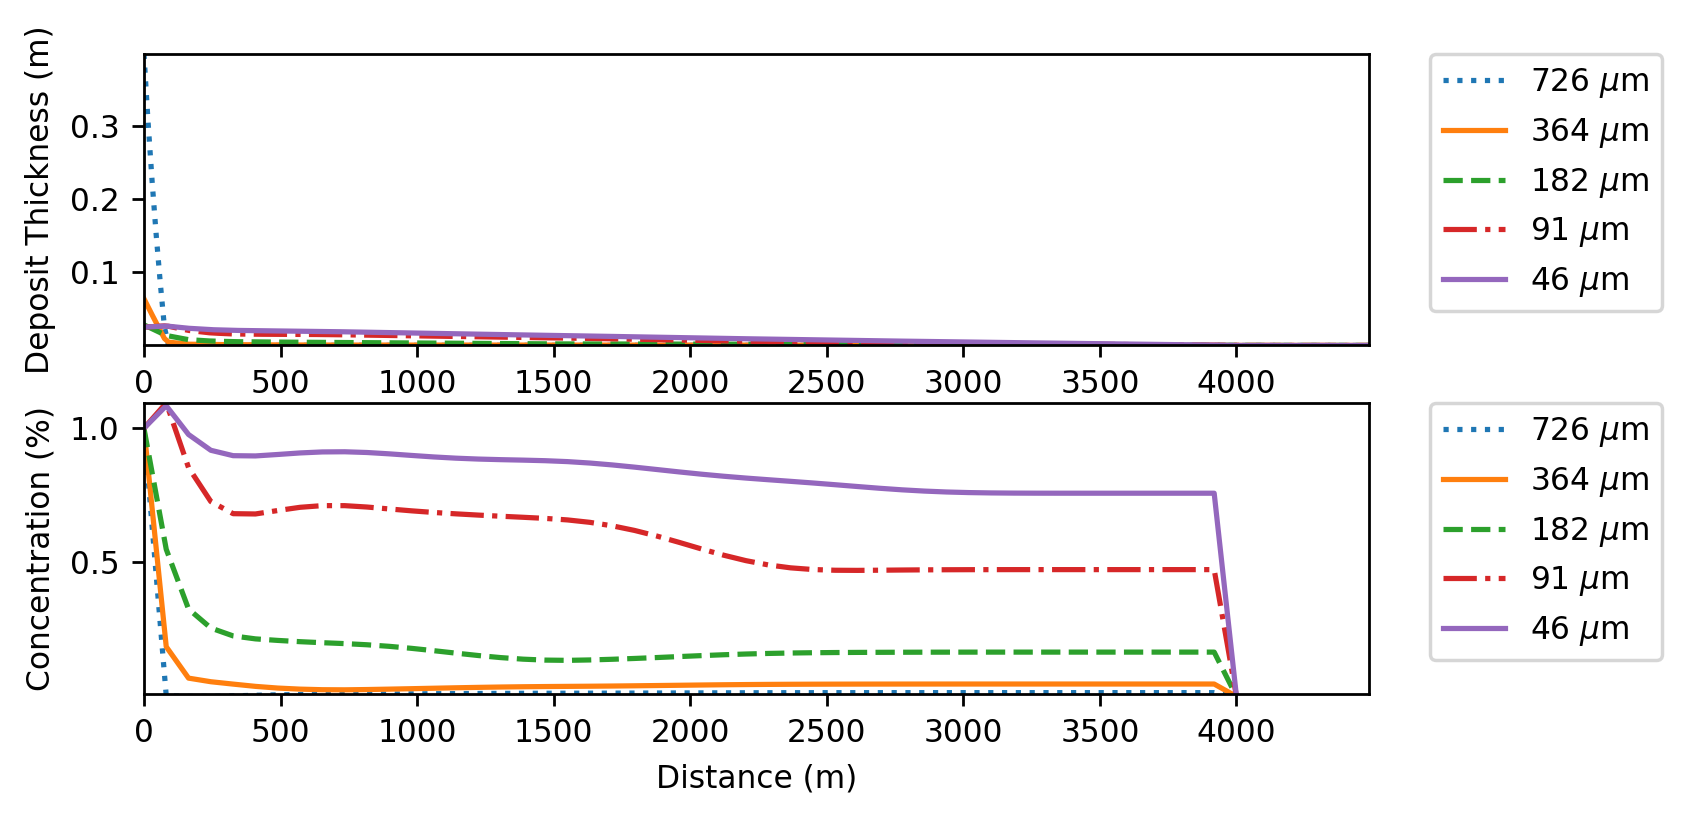

In [3]:
plot_result(C, deposit)

In [4]:
%%time
if __name__ == "__main__":

    read_setfile("config_g5_300grid_thai_revised_1.ini")
    number_of_training_data = 5500
    
    Rw=np.random.uniform(1700,4500,number_of_training_data)
    U0=np.random.uniform(2.0,10,number_of_training_data)
    H0=np.random.uniform(1.5,12,number_of_training_data)
    C0=np.random.uniform(0.02,0.0001,number_of_training_data)
    C1=np.random.uniform(0.02,0.0001,number_of_training_data)
    C2=np.random.uniform(0.02,0.0001,number_of_training_data)
    C3=np.random.uniform(0.02,0.0001,number_of_training_data)
    C4=np.random.uniform(0.02,0.0001,number_of_training_data)
    a= np.column_stack((Rw,U0,H0,C0,C1,C2,C3,C4))
    np.savetxt("start_param_random_5000_thai_g5_revised_1.csv", a, delimiter=",")
    params=np.loadtxt('start_param_random_5000_thai_g5_revised_1.csv', delimiter=',')

    start = time.time()
    first_time = True
    for i in range(params.shape[0]):
        (x,C,x_dep,deposit) = forward(params[i, :])
        if first_time:
            eta = np.array([deposit.flatten()])
            first_time = False
        else:
            eta = np.vstack((eta, deposit.flatten()))
    np.savetxt('eta_5000_g6_300grid_thai_g5_revised_1.csv', eta, delimiter=',')


CPU times: user 8h 8min 13s, sys: 2min, total: 8h 10min 13s
Wall time: 6h 43min 12s


In [5]:

import numpy as np
icond = np.loadtxt('start_param_random_5000_thai_g5_revised_1.csv', delimiter=',')
#icond_new=icond[:,1:]
#print(icond_new.shape)
#np.savetxt('start_param_random_5000_g6_300grid_Rwcnst_new_H_5000_12_06.csv',icond_new, delimiter=',')
#icond_a = np.loadtxt('start_param_random_5000_g6_300grid_Rwcnst_new_H_5000_12_06.csv', delimiter=',')
print(icond.shape)
eta = np.loadtxt('eta_5000_g6_300grid_thai_g5_revised_1.csv', delimiter=',')

#print(icond.shape)
print(eta.shape)


(5500, 8)
(5500, 1500)
